In [1]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from torchvision import models
from torchvision import transforms
from torchvision.io import read_image

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

from tqdm import tqdm

import random
import os, sys

sys.path.append('../add/')

from gradLayer import GradLayer

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

torch.backends.cudnn.deterministic = True

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
class CustomImageDataset(Dataset):
    def __init__(self, df, transform=None):

        self.df = df
        
        self.device = device
        
        self.transform = transform

    def __len__(self):
        return len(self.df)


    def __getitem__(self, idx):
        if idx >= len(self): raise StopIteration

        img = read_image(self.df.loc[idx, 'img_path'])[:3,:,:]
        filename = self.df.loc[idx, 'filename']
        sign = self.df.loc[idx, 'sign']
        
        if self.transform:
            img = self.transform(img)

        return img, filename, sign
    
    def getData(self):
        return list(self)

In [6]:
def createDataFrame():
    
    train_df = pd.read_csv('../../data/train.csv')
    train_df['img_path'] = '../../data/avia-train/avia-train/' + train_df['filename'] + '.png'
    
    test_df = pd.read_csv('../../data/test.csv')
    test_df['img_path'] = '../../data/avia-test/avia-test/' + test_df['filename'] + '.png'
    test_df['sign'] = -1
    
    test_e_df = pd.read_csv('../../data/test_extended.csv', index_col='filename')
    
    test_e_df = test_e_df.drop(test_df['filename'])
    test_e_df['filename'] = test_e_df.index
    
    test_e_df['img_path'] = '../../data/avia-test-extended/avia-test-extended/' + test_e_df['filename'] + '.jpeg'
    test_e_df['sign'] = -1
    
    df = pd.concat((train_df, test_df, test_e_df)).reset_index(drop=True)
    
    df['sign'] = df['sign'].astype('float64')
    
    return df

In [7]:
def createDataLoader(df, batch_size=None, shuffle=False, transform=None):

    batch_size = batch_size if batch_size else len(df)
    
    dataset = CustomImageDataset(df, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    
    return dataset, dataloader

In [8]:
df = createDataFrame()

In [9]:
model = models.resnet50(pretrained=True)
    
model.fc = torch.nn.Sequential(
    nn.Linear(model.fc.in_features, 1),
    nn.Sigmoid()
)

weight = torch.tensor([sum(df['sign'] == 1) / sum(df['sign'] != -1)])
criterion = nn.BCELoss(weight=weight, reduction='mean')
criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [10]:
%%time

def f():
    log = {'loss': {'train': [], 'val': []}, 'bestModel': None}
    
    epochs = 20
    
    train_df, val_df = train_test_split(df[df['sign'] != -1], test_size=0.2, random_state=42)
    train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)
    
    traintransform = transforms.Compose([
        transforms.ToPILImage(),

        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),

        transforms.ToTensor(),
        GradLayer(),
        lambda x: x.expand(3, *x.shape[1:])
    ])
    _, train_dataloader = createDataLoader(train_df, batch_size=100, shuffle=True, transform=traintransform)
    
    valTransform = transforms.Compose([
        transforms.ToPILImage(),

        transforms.ToTensor(),
        GradLayer(),
        lambda x: x.expand(3, *x.shape[1:])
    ])
    _, val_dataloader = createDataLoader(val_df, batch_size=100, shuffle=True, transform=valTransform)
    
    
    model.to(device)
    
    for epoch in range(epochs):
        # Train
        model.train()
        running_loss = 0
        for X, _, y in train_dataloader:
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device).float().reshape(-1, 1)
            
            y_predict = model(X)

            loss = criterion(y_predict, y)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        log['loss']['train'].append(running_loss/len(train_dataloader))
        
        # Val
        model.eval()
        running_loss = 0
        for X, _, y in val_dataloader:

            X, y = X.to(device), y.to(device).float()

            y_predicted1 = model(X)
            y_predicted2 = model(transforms.RandomHorizontalFlip(p=1)(X))
            y_predicted3 = model(transforms.RandomVerticalFlip(p=1)(X))
            y_predicted4 = model(transforms.RandomVerticalFlip(p=1)(transforms.RandomHorizontalFlip(p=1)(X)))

            y_predict = torch.cat((y_predicted1, y_predicted2, y_predicted3, y_predicted4), dim=1).mean(dim=1)

            loss = criterion(y_predict, y)
            running_loss += loss.item()


        log['loss']['val'].append(running_loss/len(val_dataloader))

        if not log['bestModel'] or log['loss']['val'][-1] < min(log['loss']['val'][:-1]):
            log['bestModel'] = model
            log['bestEpoch'] = epoch + 1

        print(f"Epoch: {epoch+1} / {epochs} | Train loss: {log['loss']['train'][-1]} | Val loss: {log['loss']['val'][-1]}")
            
    return log
        
log = f()    

Epoch: 1 / 20 | Train loss: 0.06182186408005805 | Val loss: 0.029231064819863865
Epoch: 2 / 20 | Train loss: 0.0331076131909188 | Val loss: 0.022664718906439486
Epoch: 3 / 20 | Train loss: 0.02598548860075962 | Val loss: 0.017483933082234764
Epoch: 4 / 20 | Train loss: 0.021846700850574965 | Val loss: 0.019198904804412335
Epoch: 5 / 20 | Train loss: 0.018967390545722412 | Val loss: 0.020899439659265297
Epoch: 6 / 20 | Train loss: 0.01669253991920516 | Val loss: 0.015500479289108799
Epoch: 7 / 20 | Train loss: 0.01565448764335723 | Val loss: 0.014669968739211087
Epoch: 8 / 20 | Train loss: 0.01466351008859938 | Val loss: 0.01277929575123366
Epoch: 9 / 20 | Train loss: 0.012837981640166756 | Val loss: 0.01320464007319912
Epoch: 10 / 20 | Train loss: 0.011883642106507736 | Val loss: 0.016262270787376024
Epoch: 11 / 20 | Train loss: 0.010618110141299859 | Val loss: 0.014858589995475043
Epoch: 12 / 20 | Train loss: 0.010955106359476366 | Val loss: 0.010622174848639776
Epoch: 13 / 20 | Train

19


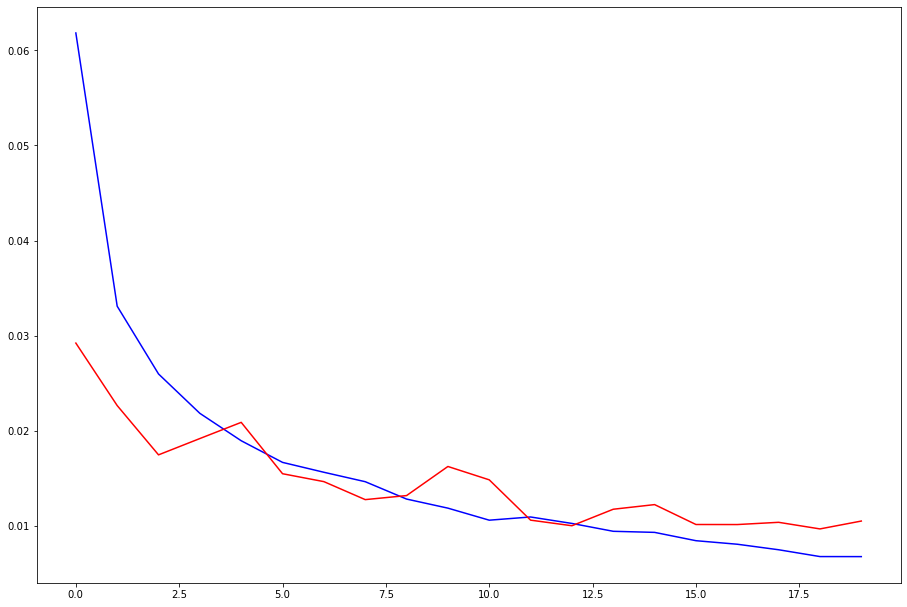

In [11]:
print(log['bestEpoch'])

fig = plt.figure()
axes = fig.add_axes([1, 1, 2, 2])

axes.plot(range(len(log['loss']['train'])), log['loss']['train'], 'b')
axes.plot(range(len(log['loss']['val'])), log['loss']['val'], 'r')
plt.show()

In [12]:
model = log['bestModel']

In [13]:
%%time
with torch.no_grad():
    model.eval()
    model.to(device)

    test_df = df.copy()
    test_df = test_df.reset_index(drop=True)
    
    testTransform = transforms.Compose([
        transforms.ToPILImage(),

        transforms.ToTensor(),
        GradLayer(),
        lambda x: x.expand(3, *x.shape[1:])
    ])
    _, test_dataloader = createDataLoader(test_df, batch_size=500, shuffle=True, transform=testTransform)
    
    filenames = []
    sign = []
    predicteds = [[], [], [], []]
    
    for X, filename, y in test_dataloader:

        X = X.to(device)
        
        predicteds[0].append(model(X).reshape(-1).cpu())
        predicteds[1].append(model(transforms.RandomHorizontalFlip(p=1)(X)).reshape(-1).cpu())
        predicteds[2].append(model(transforms.RandomVerticalFlip(p=1)(X)).reshape(-1).cpu())
        predicteds[3].append(model(transforms.RandomVerticalFlip(p=1)(transforms.RandomHorizontalFlip(p=1)(X))).reshape(-1).cpu())
        
        sign.append(y)
        filenames += filename
        
predicteds[0] = torch.cat(predicteds[0], 0)
predicteds[1] = torch.cat(predicteds[1], 0)
predicteds[2] = torch.cat(predicteds[2], 0)
predicteds[3] = torch.cat(predicteds[3], 0)

sign = torch.cat(sign)

Wall time: 10min 36s


In [14]:
modelName = 'resnet50'
filterName = 'gradLayer'

In [15]:
predict_df1 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'v': 0,
    
    'predict': predicteds[0],
    'sign': sign,
})

predict_df2 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'v': 1,
    
    'predict': predicteds[1],
    'sign': sign,
})

predict_df3 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'v': 2,
    
    'predict': predicteds[2],
    'sign': sign,
})

predict_df4 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'v': 3,
    
    'predict': predicteds[3],
    'sign': sign,
})

In [16]:
predict_df = pd.concat((predict_df1, predict_df2, predict_df3, predict_df4)).reset_index(drop=True)

In [17]:
predict_df

filename     model     filter  v  \
0       017d7c6a-aa45-4882-bfa8-e86711096321  resnet50  gradLayer  0   
1       d9becb0d-9d2a-4c56-bb5c-63412536eb64  resnet50  gradLayer  0   
2       83c36444-ad1e-4ef0-ab31-9e28ef1315d9  resnet50  gradLayer  0   
3       0670aeb3-e47c-4bc1-aefb-7c6b15f33a75  resnet50  gradLayer  0   
4       0ad3333c-94ed-412b-b58b-c9fc3edfe270  resnet50  gradLayer  0   
...                                      ...       ...        ... ..   
528315  44ce9645-bf11-4fa6-b60f-5045937d94d1  resnet50  gradLayer  3   
528316  8a82cacf-b586-4f88-823b-6cc5d7c55ba6  resnet50  gradLayer  3   
528317  9f8f4b43-01c7-4240-b4fd-80ac8b44c71e  resnet50  gradLayer  3   
528318  d21f5447-1bc0-461f-a176-16e18431b41d  resnet50  gradLayer  3   
528319  bbdfb269-e64c-4549-83e7-bb6a773ff1ef  resnet50  gradLayer  3   

             predict  sign  
0       5.338760e-04  -1.0  
1       3.677105e-05  -1.0  
2       1.046573e-04  -1.0  
3       1.947487e-04  -1.0  
4       2.612673e-04   0.0  
...              ...   ...  
528315  7.849756e-04  -1.0  
528316  1.163763e-01   0.0  
528317  6.338361e-12  -1.0  
528318  1.039726e-04  -1.0  
528319  3.235303e-04  -1.0  

[528320 rows x 6 columns]

In [18]:
predict_df.to_csv(f'predicteds/{modelName}_{filterName}.csv', index=False)